<a href="https://colab.research.google.com/github/pamulah/test-thesis/blob/master/CNN_modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
K.set_image_dim_ordering('th')
import numpy as np
from sklearn import preprocessing
from keras.datasets import mnist
import glob
import os
import random
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load data
X_train = numpy.load('drive/My Drive/X_train.npy')
y_train = numpy.load('drive/My Drive/y_train.npy')
X_test = numpy.load('drive/My Drive/X_test.npy')
y_test = numpy.load('drive/My Drive/y_test.npy')
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_val.shape, y_val.shape)
print (X_test.shape, y_test.shape)

X_train = X_train.reshape(X_train.shape[0], 1, 60, 87).astype('float32')
X_val = X_val.reshape(X_val.shape[0], 1, 60, 87).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 60, 87).astype('float32')
print (X_train.shape)
print (X_test.shape)
# normalize inputs from 0-255 to 0-1
#X_train = X_train / 255
#X_val = 
#X_test = X_test / 255
# one hot encode outputs
#y_train = np_utils.to_categorical(y_train)
#y_val = np_utils.to_categorical(y_val)


#y_test = np_utils.to_categorical(y_test)
#num_classes = y_test.shape[1]

(24464, 60, 87) (24464,)
(6117, 60, 87) (6117,)
(10793, 60, 87) (10793,)
(24464, 1, 60, 87)
(10793, 1, 60, 87)


[ 19 101 168 171 218 224 399 407 420 532]


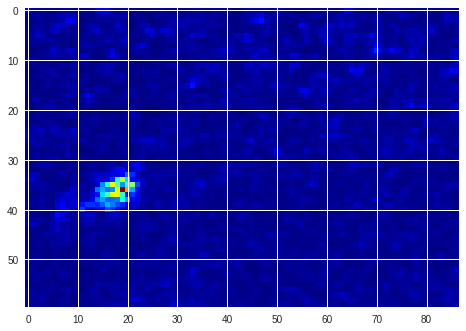

In [0]:
# exemplary bird call (really clear one)
a = 1905
y_train[a]==1
b = numpy.where(y_train== 1)[0]
print(b[0:10])

plt.imshow(X_train[407,0], cmap=plt.get_cmap('jet'))


In [0]:
def roc_auc_score(y_true, y_pred):
    """ ROC AUC Score.
    Approximates the Area Under Curve score, using approximation based on
    the Wilcoxon-Mann-Whitney U statistic.
    Yan, L., Dodier, R., Mozer, M. C., & Wolniewicz, R. (2003).
    Optimizing Classifier Performance via an Approximation to the Wilcoxon-Mann-Whitney Statistic.
    Measures overall performance for a full range of threshold levels.
    Arguments:
        y_pred: `Tensor`. Predicted values.
        y_true: `Tensor` . Targets (labels), a probability distribution.
    """
    with tf.name_scope("RocAucScore"):
        pos = tf.boolean_mask(y_pred, tf.cast(y_true, tf.bool))
        neg = tf.boolean_mask(y_pred, ~tf.cast(y_true, tf.bool))
        pos = tf.expand_dims(pos, 0)
        neg = tf.expand_dims(neg, 1)
        # original paper suggests performance is robust to exact parameter choice
        gamma = 0.2
        p     = 3
        difference = tf.zeros_like(pos * neg) + pos - neg - gamma
        masked = tf.boolean_mask(difference, difference < 0.0)
        return tf.reduce_sum(tf.pow(-masked, p))

In [0]:
 #def roc_auc_score_loss(y_true, y_pred):
  #  return roc_auc_score(y_true, y_pred)

In [0]:
#del model
def larger_model():
  model = Sequential()
  model.add(Conv2D(20, (3,3), input_shape=(1, 60, 87), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(20, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(20, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))
  # Compile model
  #model.compile(loss=roc_auc_score_loss, optimizer='adam', metrics=['accuracy','mae'])
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model
  

In [0]:
#@title
# printing AUC score on validation set, after every epoch
import keras
from sklearn.metrics import roc_auc_score

class Histories(keras.callbacks.Callback):
	def on_train_begin(self, logs={}):
		self.aucs = []
		self.losses = []

	def on_train_end(self, logs={}):
		return

	def on_epoch_begin(self, epoch, logs={}):
		return

	def on_epoch_end(self, epoch, logs={}):
		self.losses.append(logs.get('loss'))
		y_pred = self.model.predict(self.validation_data[0])
		self.aucs.append(roc_auc_score(self.validation_data[1], y_pred))
		a = (roc_auc_score(self.validation_data[1], y_pred))
		print(" AUC_on_val: %f " % a)
		return

	def on_batch_begin(self, batch, logs={}):
		return

	def on_batch_end(self, batch, logs={}):    return


In [7]:
# build the model
#del model
model = larger_model()

from sklearn.utils import class_weight
print(numpy.unique(y_train))
class_weights = class_weight.compute_class_weight('balanced',numpy.unique(y_train),y_train)
print(class_weights)

[0 1]
[ 0.50934832 27.24276169]


In [8]:
#from keras.models import load_model
#model = load_model('drive/My Drive/Colab Notebooks/models/CNN_30e.h5')


# Fit the model
histories = Histories()
hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=40, batch_size=32, callbacks=[histories], class_weight = class_weights)
print(histories.aucs)


# list all data in history
c = hist.history.keys()
print(hist.history.keys())

Train on 24464 samples, validate on 6117 samples
Epoch 1/40
24464/24464 [==============================] - 16s 645us/step - loss: 0.1052 - acc: 0.9809 - val_loss: 0.0900 - val_acc: 0.9820
 AUC_on_val: 0.566675 
Epoch 2/40
24464/24464 [==============================] - 13s 530us/step - loss: 0.0961 - acc: 0.9816 - val_loss: 0.0905 - val_acc: 0.9820
 AUC_on_val: 0.525796 
Epoch 3/40
24464/24464 [==============================] - 14s 566us/step - loss: 0.0958 - acc: 0.9816 - val_loss: 0.0898 - val_acc: 0.9820
 AUC_on_val: 0.544388 
Epoch 4/40
24464/24464 [==============================] - 14s 589us/step - loss: 0.0950 - acc: 0.9816 - val_loss: 0.0931 - val_acc: 0.9820
 AUC_on_val: 0.546108 
Epoch 5/40
24464/24464 [==============================] - 14s 582us/step - loss: 0.0950 - acc: 0.9816 - val_loss: 0.0923 - val_acc: 0.9820
 AUC_on_val: 0.543858 
Epoch 6/40
24464/24464 [==============================] - 14s 571us/step - loss: 0.0945 - acc: 0.9816 - val_loss: 0.0907 - val_acc: 0.9820
 A

CNN Error for val set: 0.95%
CNN Error for test set: 3.85%


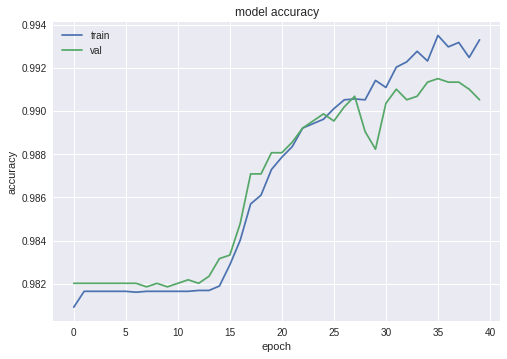

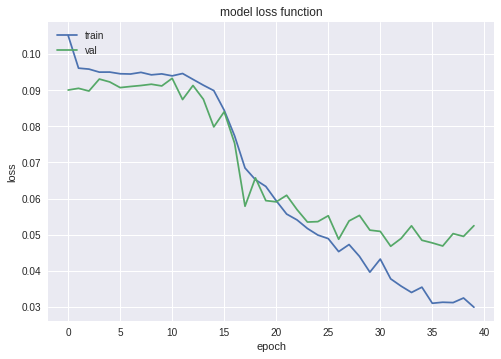

AUC: 0.786


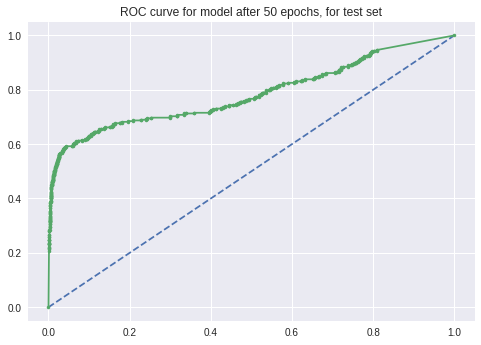

In [9]:
# Final evaluation of the model
scores_val = model.evaluate(X_val, y_val, verbose=0)
print("CNN Error for val set: %.2f%%" % (100-scores_val[1]*100))
scores_test = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error for test set: %.2f%%" % (100-scores_test[1]*100))

# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss function')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# calculate AUC of final model on a test set
probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
#probs = probs[:, 1]
y_test2 = numpy.load('drive/My Drive/y_test.npy')  # osobno, bo inny wymiar

auc = roc_auc_score(y_test2, probs)
print('AUC: %.3f' % auc)

fpr, tpr, thresholds = roc_curve(y_test2, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
plt.title('ROC curve for model after 50 epochs, for test set')
pyplot.show()

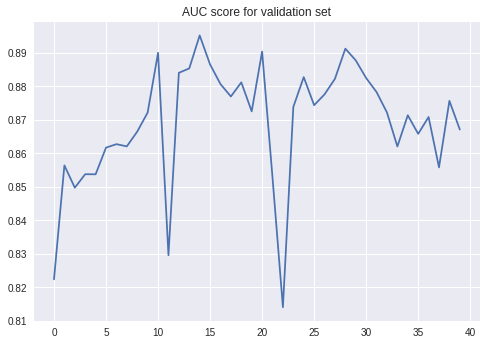

In [0]:
c = [0.8224177853110766, 0.8563857317977512, 0.8497465078620396, 0.8537660608078455, 0.8537327663180835, 0.8616871225993916, 0.862714711624317, 0.8620669824598575, 0.8664618551084341, 0.8721279719115578, 0.8899556577931806, 0.829618475415046, 0.8839823236527082, 0.8852959426124067, 0.8951352210300104, 0.8864794103848539, 0.8806226069585483, 0.8769284319808708, 0.881141698321655, 0.8724957246848374, 0.8903309774959517, 0.8527717662726819, 0.8141168636590644, 0.8738002633291463, 0.8827080527263647, 0.87433070508649, 0.877562540672246, 0.8822018251433934, 0.8911815003707796, 0.8876901191034702, 0.8824227794845407, 0.8782481044841625, 0.8721605097083704, 0.8620238509617566, 0.8713387411656098, 0.8657982353920427, 0.8708219198813506, 0.8557992947621713, 0.8756344870378499, 0.8670793165549284]
plt.plot(c)
plt.title('AUC score for validation set')
pyplot.show()

In [0]:
model.save('drive/My Drive/Colab Notebooks/models/CNN_40e_weights.h5')

In [0]:
model.save_weights('drive/My Drive/Colab Notebooks/models/CNN_60e_weights.h5')

In [0]:
del model

In [0]:
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# check 5 epochs
early_stop = EarlyStopping(monitor='val_acc', patience=5, mode='max') 

callbacks_list = [checkpoint, early_stop]

history = model.fit(x, y, validation_data=(x_test, y_test), epochs=100, callbacks=callbacks_list)